<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Указания к выполнению учебного проекта:
- в качестве моделей допустимо использовать только линейную регрессию;
- разделение на тренировочную и валидационную выборку провести в соотношнеии 75:25;
- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- бюджет на разработку скважин в регионе — 10 млрд рублей;
- доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Загрузка модулей:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Загрузка данных:

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_0.csv")
    data_1 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_1.csv")
    data_2 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_2.csv")
    
#Для всех трех регионов действия будут однотипными, поэтому объединим данные с список:
data = [data_0, data_1, data_2]

Рассмотрим содержимое таблиц:

In [3]:
for datum in data:
    datum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Типы данных соответствуют необходимым. Признак `id` как идентификатор месторождения не следует учитывать при построении модели.  
Проверим распределения остальных признаков и целевой переменной:

Регион 0


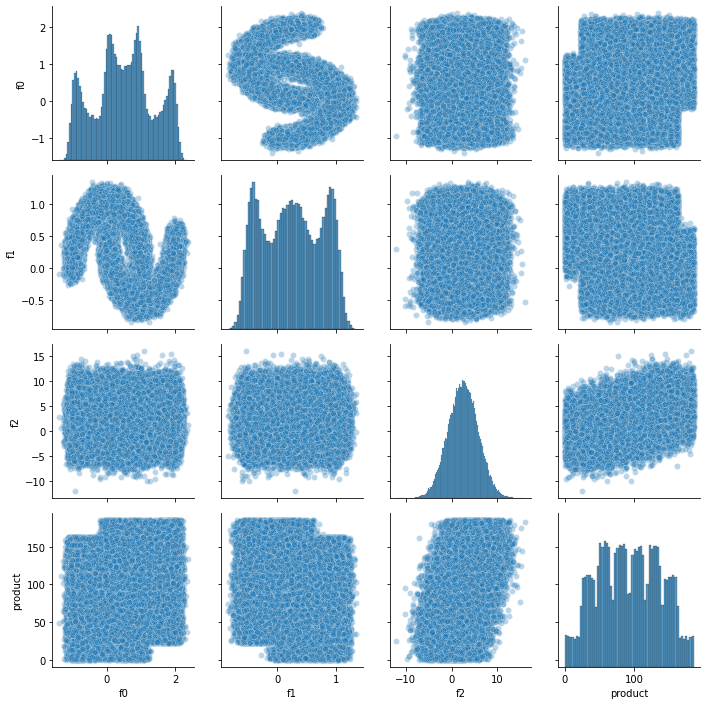

Регион 1


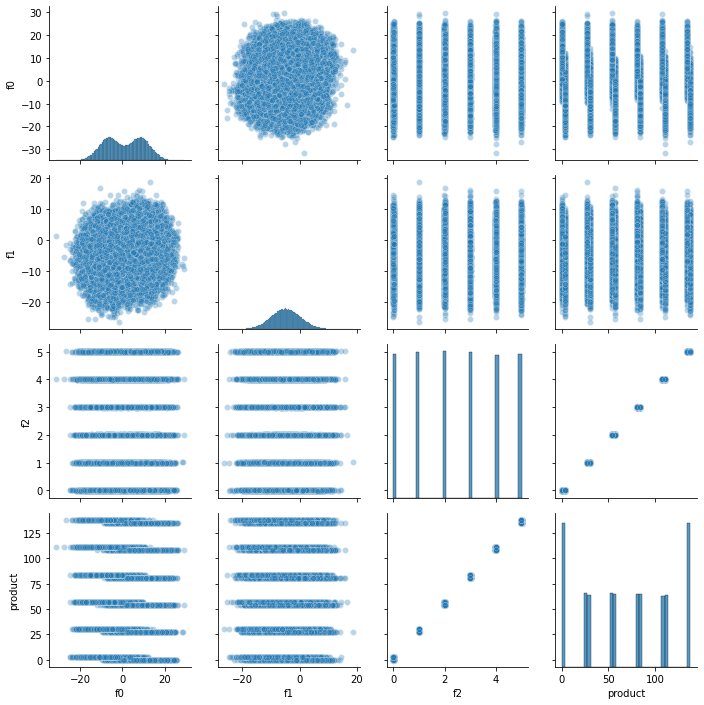

Регион 2


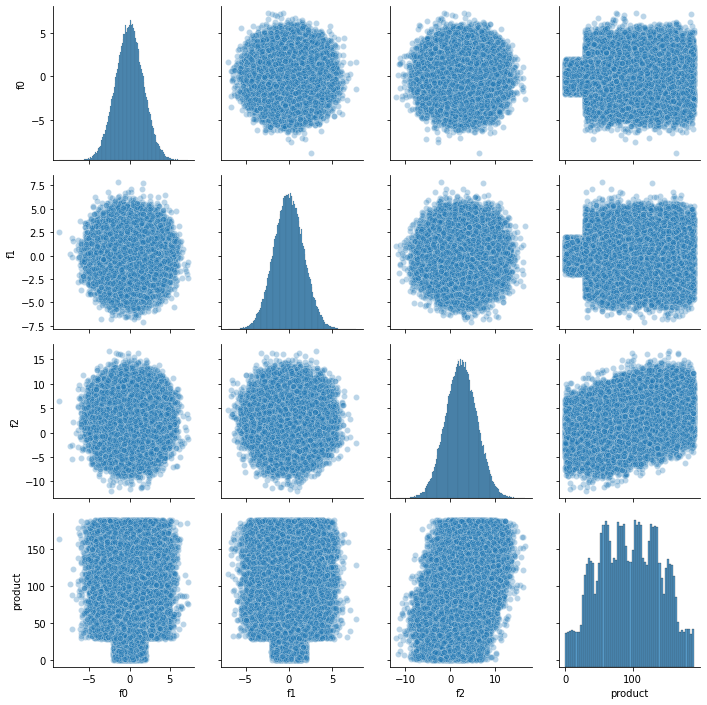

In [4]:
i = 0
for datum in data:
    print(f"Регион {i}")
    g = sns.PairGrid(datum)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot, alpha=0.3)
    plt.show()
    i += 1

*Распределения признаков* для разных регионов существенно *различаются*, таким обазом, **необходимо построение отдельной  модели** предсказания продуктивности скважины **для каждого региона**.  

Продуктивность для всех регионов положительна. Общее распределение для каждого региона складывается из 8 отдельных распределений, возможно данные получены объединением результатов нескольких независимых источников. Для региона 1 распределение разбивается на восемь полностью отдельных распределений. Распределения других признаков, как было указано выше, различны для разных регионов, но явные аномалии отсутствуют и диапазоны изменения различных признаков приблизительно сопоставимы. Таким образом, **обработка аномалий и машстабирование признаков не требуется**.  

Для всех регионов сильнее всего выражена линейная зависимость продуктивности от признака `f2`. Для `региона 1` отклонение от линейности при этом очень мало, что позволяет ожидать наибольшее качество модели именно для этого региона.  
Влияние признаков `f0` и `f1` для `региона 1` практически отсутствует. Для `региона 0` наблюдается слабая линейная связь продуктивности и признаков `f0` и `f1`, а случае `региона 2` связь также слабая, а кроме того нелинейная (при абсолютном значении признаков `f0` и `f1` большое 2,5, продуктивность ниже ~30 не наблюдается). Для учета такой нелинейности при построении модели могут быть добавлены квадратичные члены.  

**Выводы**
1. Данные не содержат пропусков и выбросов, поэтому предварительная обработка не требуется;
2. Диапазоны изменения признаков сопоставимы, машстабирование данных может не проводиться;
3. Признак `f2` линейно влияет на целевую переменную, зависимость от данного признака наиболее сильная, что может быть использовано для построения линейной модели.
3. Для региона 0 слабое линейное влияние оказывают также признаки f0 и f1 (влияние менее сильное). В регионе 2 признаки f0 и f1 влияют также слабо, но нелинейно. Для учета этого в модели могут быть учтены квадраты признаков.

## Обучение и проверка модели

Подготовим данные для обучения - разобьем данные на тренировочные и валидационные выборки:

In [5]:
#Для хранения наборов по регионам созданим списки:
features_train = []
features_valid = []
target_train = []
target_valid = []
#Разделим исходные данные в соотношении 75:25:
for datum in data:
    f_t, f_v, t_t, t_v = train_test_split(datum.drop(['id', 'product'], axis=1),
                                          datum['product'],
                                          test_size=0.25, random_state=123)
    features_train.append(f_t)
    features_valid.append(f_v)
    target_train.append(t_t)
    target_valid.append(t_v)

Обучение моделей:

In [6]:
#Массив для хранения моделей, предсказаний на валидационной выборке и оценок моделей
models = []
results = []
scores = []

for i in range(3):
    #Добавление квадртатичных членов в модель:
    poly = PolynomialFeatures(2)
    features_train[i] = pd.DataFrame(poly.fit_transform(features_train[i]))
    features_valid[i] = pd.DataFrame(poly.transform(features_valid[i]))
    
    #Инициализация и обучение моделей:
    model = LinearRegression()
    model.fit(features_train[i], target_train[i])
    models.append(model)
    
    #Расчет предсказаний и среднеквадратичной ошибки моделей:
    prediction = model.predict(features_valid[i])
    scores.append(mean_squared_error(target_valid[i], prediction)**0.5)
    print(f"Для региона {i} средний запас сырья составляет {np.mean(prediction):0.3f} тыс. баррелей, RMSE - {scores[i]:0.3f}")
    result = pd.DataFrame({'fact' : target_valid[i],
                           'predicted' : prediction
                          })
    results.append(result)

Для региона 0 средний запас сырья составляет 92.554 тыс. баррелей, RMSE - 37.648
Для региона 1 средний запас сырья составляет 69.280 тыс. баррелей, RMSE - 0.895
Для региона 2 средний запас сырья составляет 95.143 тыс. баррелей, RMSE - 38.864


Результаты для регионов 0 и 2 близки как по среднему запасу сырья, так и по среднеквадратичному отклонению. Регион 1 выделяется меньшим средним значением предсказываемых запасов, однако точность предсказаний значительно выше. Преимущество какого-либо региона неоднозначно, требуется дополнительная проверка для установления риска и прибыли при разработке скважин в каждом из регионов.

## Подготовка к расчёту прибыли

Параметры для расчета прибыли:

In [7]:
#Бюджет на разработку скважин в регионе:
TOTAL = 10e9

#Количество разрабатываемых скважин:
N_WELLS = 200

#Стоимость разработки 1 скважины:
WELL_PRICE = TOTAL / N_WELLS

#Доход при добыче 1 тыс. баррелей: 
EARNING_PER_PROD = 450e3

Минимальные запасы сырья для безубыточной разработки скважины:

In [8]:
#Минимальные запасы должны обеспечить доход равный стоимости разработки скважины:

MINIMAL_PRODUCT = WELL_PRICE / EARNING_PER_PROD

print(f"Минимальные запасы сырья необходимые для безубыточной разработки: {MINIMAL_PRODUCT:0.3f}")

Минимальные запасы сырья необходимые для безубыточной разработки: 111.111


Минимальные запасы сырья превышают средние запасы, предсказываемые полученной моделью.  
По условию разработка планируется только на 200 лучших месторождениях, следовательно для рентабельности разработки необходимо превышение средних запасов только на 200 лучших месторождениях. Проверим средние запасы для 200 лучших предсказаний по каждому региону и сравним их со средними запасами в 200 случайно отобранных месторождений:

In [9]:
print('200 произвольных месторождений:')
for i in range(3):
    random_200_mean = np.mean(results[i].fact.sample(200))
    print(f"Для региона {i} средний запас сырья составляет {random_200_mean:0.3f} тыс. баррелей")

print('')
print('200 лучших (по результатам моделирования) месторождений:')
for i in range(3):
    top_200_mean = np.mean(results[i].sort_values(by='predicted', ascending=False).head(200)['fact'])
    print(f"Для региона {i} средний запас сырья составляет {top_200_mean:0.3f} тыс. баррелей")

200 произвольных месторождений:
Для региона 0 средний запас сырья составляет 89.262 тыс. баррелей
Для региона 1 средний запас сырья составляет 68.441 тыс. баррелей
Для региона 2 средний запас сырья составляет 86.539 тыс. баррелей

200 лучших (по результатам моделирования) месторождений:
Для региона 0 средний запас сырья составляет 150.424 тыс. баррелей
Для региона 1 средний запас сырья составляет 137.945 тыс. баррелей
Для региона 2 средний запас сырья составляет 138.829 тыс. баррелей


In [10]:
print('200 произвольных месторождений:')
for i in range(3):
    random_200_mean = np.mean(results[i].fact.sample(200))
    print(f"Для региона {i} средний запас сырья составляет {random_200_mean:0.3f} тыс. баррелей")

print('')
print('200 лучших (по результатам моделирования) месторождений:')
for i in range(3):
    top_200_mean = np.mean(results[i].sort_values(by='predicted', ascending=False).head(200)['fact'])
    print(f"Для региона {i} средний запас сырья составляет {top_200_mean:0.3f} тыс. баррелей")

200 произвольных месторождений:
Для региона 0 средний запас сырья составляет 90.353 тыс. баррелей
Для региона 1 средний запас сырья составляет 68.917 тыс. баррелей
Для региона 2 средний запас сырья составляет 92.406 тыс. баррелей

200 лучших (по результатам моделирования) месторождений:
Для региона 0 средний запас сырья составляет 150.424 тыс. баррелей
Для региона 1 средний запас сырья составляет 137.945 тыс. баррелей
Для региона 2 средний запас сырья составляет 138.829 тыс. баррелей


Средние запасы в отобранных по предсказаниям модели месторождениях превышают средние запасы по регионам в целом и средние запасы в 200 случайно отобранных месторождениях (на 50 - 70 тыс. баррелей). Использование модели для `региона 1`, обладающей наибольшей точностью, приводит к наибольшему росту средних запасов по выборке (на 70 тыс. баррелей соответственно).  
Средние запасы в 200 лучших месторождениях в каждом регионе превышают пороговое значение, следовательно при отборе месторождений по предсказаниям модели разработка может быть рентабельной.

## Расчёт прибыли и рисков 

Поскольку предсказания модели могут сильно отличаться от фактических значений запасов, такие предсказания должны использоваться только для выбора наиболее перспективных месторождений. Проверка прибыли должна осуществляться по фактически значениям запасов. Реализуем фукнцию для отбора `n` лучших месторождений по предсказаниям модели и расчету выручки от их разработки:

In [11]:
#Функция для расчета выручки от разработки n лучших (по данным модели) месторождений:
def top_well_earnings(result, n, earning_per_prod=EARNING_PER_PROD):
    #Определение лучших месторождений:
    top_wells = result.sort_values(by='predicted', ascending=False).head(n)
    #Суммарные фактические запасы в отобранных месторождениях:
    earnings = top_wells.fact.sum()*earning_per_prod
    
    return earnings

#Проверка работы функции, расчет максимальной выручки от разработки в регионах:
for i in range(3):
    max_earnings = top_well_earnings(results[i], 200)
    print(f"Выручка от 200 лучших месторождений в регионе {i}: {max_earnings / 1e9:0.02f} млрд. руб.")

Выручка от 200 лучших месторождений в регионе 0: 13.54 млрд. руб.
Выручка от 200 лучших месторождений в регионе 1: 12.42 млрд. руб.
Выручка от 200 лучших месторождений в регионе 2: 12.49 млрд. руб.


Если отбор лучших производить среди всех 25000 месторождений (проверка модели производится на отложенной выборке, не использованной для обучения модели), выручка во всех регионах превышает планируемые вложения (10 млрд. руб.). В реальности выбор преварительная разведка всех месторождений экономически не оправдана, поэтому отбор лучших должен осуществляться из ограниченной подвыборки месторождений (по условию из 500). Для обеспечения большей правдоподобности выборки будем осуществлять с возможными повторениями (bootstrap):

In [12]:
#Функция для расчета выручки по ограниченной подвыборке с возможными повторениями:
def bootstraped_earnings(result, k_to_select, n_to_develop, random_state=12345, well_price=WELL_PRICE):
    result_sample = result.sample(k_to_select, replace=True, random_state=random_state)
    net_earnings = top_well_earnings(result_sample, n_to_develop) - n_to_develop*well_price
    return net_earnings

#Проверка работы функции, расчет максимальной выручки от разработки в регионах:
for i in range(3):
    some_earnings = bootstraped_earnings(results[i], 500, 200)
    print(f"Выручка от 200 лучших из 500 случайных месторождений в регионе {i}: {some_earnings / 1e9:0.02f} млрд. руб.")

Выручка от 200 лучших из 500 случайных месторождений в регионе 0: 0.48 млрд. руб.
Выручка от 200 лучших из 500 случайных месторождений в регионе 1: 0.58 млрд. руб.
Выручка от 200 лучших из 500 случайных месторождений в регионе 2: 0.86 млрд. руб.


При выборе 200 лучших из 500 случайно отобранных месторождений результаты значительно хуже чем при отборе из всех возможных месторождений. Проверим распределение чистой прибыли при таком подходе и вероятность получения убытка:

In [13]:
#Задание случайных состояний:
state = np.random.RandomState(12345)

#Проверка регионов добычи:
for j in range(3):
    region_earnings = []    
    for i in range(1000):
        earnings = bootstraped_earnings(results[j], 500, 200,  random_state=state)
        region_earnings.append(earnings)
    region_earnings = pd.Series(region_earnings)
    print(f'Результаты для региона {j}:')
    print(f'Средняя прибыль: {region_earnings.mean()/1e6:0.2f} млн. руб.')
    print(f'95%-ый доверительный интервал прибыли: {region_earnings.quantile(0.025)/1e6:0.2f} - {region_earnings.quantile(0.975)/1e6:0.2f} млн. руб.')
    print(f'Вероятность убытка: {(region_earnings<0).mean()*100:0.2f} %')
    print()

Результаты для региона 0:
Средняя прибыль: 476.77 млн. руб.
95%-ый доверительный интервал прибыли: -2.98 - 999.59 млн. руб.
Вероятность убытка: 2.70 %

Результаты для региона 1:
Средняя прибыль: 473.86 млн. руб.
95%-ый доверительный интервал прибыли: 73.18 - 869.52 млн. руб.
Вероятность убытка: 0.80 %

Результаты для региона 2:
Средняя прибыль: 563.01 млн. руб.
95%-ый доверительный интервал прибыли: 14.03 - 1086.97 млн. руб.
Вероятность убытка: 2.50 %



В `регионе 0` вероятность получения убытка превышает установленный порог (2,5%), поэтому отрицательные значения попали в 95%-ый доверительный интервал.  
Максимальная средняя прибыль достигается при разработке в `регионе 2`, однако вероятность убытка находится равна установленному порогу. Следовательно приемлемой в поставленных условиях является только разработка месторождений в `регионе 1`, ожидаемая прибыль от разработки составит 473,86 млн. руб.  
Ожидаемая средняя прибыль от разработки месторождений в `регионе 2` является максимальной среди всех регионов, поэтому можно рассмотреть увеличение объема разведки для снижения вероятности убытков в данном регионе.

## Выводы

1. Использование линейной регрессии для оценки перспективности разработки месторождений позволяет ограничить круг разрабатываемых месторождений и повысить рентабельность их разработки.
2. Средние запасы в отобранных по предсказаниям модели месторождениях превышают средние запасы по регионам и средние запасы при случайном выборе такого числа месторождений (на 50 - 70 тыс. баррелей).
3. Наибольшее повышение значения средних запасов наблюдается при использовании наиболее точной модели (`регион 1`).
4. Оценка вероятности получения убытка показывает, что единственным приемлемым для разработки (вероятность убытка менее 2,5%) является `регион 1`. Средняя прибыль при разработке месторождений в этом регионе составляет 473.86 млн. руб., 95%-ый доверительный интервал для прибыли - 73.18 - 869.52 млн. руб.
5. Оценка вероятности получения убытка для `региона 2` равна пороговому значению, учитывая наибольшее значение средней прибыли для этого региона (563.01 млн. руб.) можно рекомендовать рассмотреть возможность использования моделей линейной регресии с регуляризацией (или возможность отбора наиболее значимых признаков), либо увеличение объемов разведки для достижения приемлемой вероятности убытков в этом регионе.